# 2. Treating as sequence-to-sequence problem using language model with an attention mechanism


## Importing libraries




In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
import itertools
import matplotlib.pyplot as plt
from copy import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SOS_token = 0
EOS_token = 1

## Dataset generation


In [3]:
@dataclass
class QPSK_symbols:
    symbols = np.asarray([1 + 1j, 1 - 1j, -1 + 1j, -1 - 1j])
    amplitude = np.sqrt(2)

class OFDMDataset(Dataset):
  def __init__(self, n_of_data, nfft: int = 8, n_zero: int = 0):
    super().__init__()
    self.SOS_token = 0
    self.EOS_token = 1

    self.nfft = nfft
    self.symbols = QPSK_symbols
    self.n_of_data = n_of_data

    self.max_aplitude = self.symbols.amplitude
    self.symbols = self.symbols.symbols
    self.vocab_size = len(self.symbols)+2

    index_symbols = np.arange(0, len(self.symbols))
    self.generated_sequences_ids = np.random.choice(index_symbols, size=(n_of_data, nfft))

    self.complex_symbols = self.symbols[self.generated_sequences_ids]

    ifft_symbols = np.fft.ifft(np.asarray(self.complex_symbols))

    self.abs_values = np.abs(ifft_symbols)

    #processing to correct format
    self.generated_sequences_ids += 2
    one_vector = torch.zeros((n_of_data, 1), dtype=torch.int)

    self.generated_sequences_ids = torch.tensor(self.generated_sequences_ids)
    self.generated_sequences_ids = torch.cat((self.generated_sequences_ids, one_vector), dim=1)

    self.generated_sequences_ids_one_hot = F.one_hot(self.generated_sequences_ids, num_classes=self.vocab_size).type(torch.float32)
    self.generated_sequences_ids = self.generated_sequences_ids.type(torch.float32)

    self.abs_values = self.convert_to_vocab(self.abs_values)

    self.abs_values = torch.tensor(self.abs_values, dtype=torch.float32)
    self.abs_values = torch.cat((self.abs_values, one_vector), dim=1)

  def convert_to_vocab(self, data, bins: int = 100) -> tuple:
    max_value = np.max(data)
    bin_size = max_value/bins
    bins = [bin_size*id for id in range(bins+1)]
    new_vec = data.copy()

    for ids in range(len(bins)-1):
      i, j = np.where((data>bins[ids])&(data<=bins[ids+1]))
      new_vec[i,j] = ids
    
    n_bin = len(bins)-1
    new_vec += 2
    return new_vec

  def __len__(self):
      return self.n_of_data

  def __getitem__(self, idx):
    return self.generated_sequences_ids[idx], self.generated_sequences_ids_one_hot[idx], self.abs_values[idx]

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_vocab: int, hidden_size: int):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_vocab, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        N = input.shape[0]
        input = input.view(N, 1, 1)
        embedded = self.embedding(input)
        embedded = embedded.view(1,N, -1)
        output, hidden = self.gru(embedded, hidden)

        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size: int, output_vocab_size: int, nfft: int, dropout_p=0.4):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_vocab_size = output_vocab_size
        self.dropout_p = dropout_p
        self.nfft = nfft

        self.embedding = nn.Embedding(self.output_vocab_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.nfft)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_vocab_size)

    def forward(self, input, hidden, encoder_outputs):
        N = input.shape
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        
        hidden = hidden[0]

        if hidden.shape[0] != 1:
            hidden = hidden.unsqueeze(0)

        if embedded.shape[0] != 1:
            embedded = embedded.unsqueeze(0)

    
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded, hidden), 1)), dim=1)

        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs)

        output = torch.cat((embedded, attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)

        hidden = hidden.unsqueeze(1).permute(1,0,2)
        output, hidden = self.gru(output, hidden)

        output = F.softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [68]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, batch_size, sequence_len=9):
    encoder_hidden = encoder.initHidden(batch_size)
    encoder_outputs = None

    

    loss = 0
    accuracy = sequence_len

    for ei in range(sequence_len):
        encoder_output, encoder_hidden = encoder(
            input_tensor[:, ei], encoder_hidden)

        encoder_output_in = encoder_output.permute(1,0,2)

        if encoder_outputs == None:
          encoder_outputs = encoder_output_in
        else:
          encoder_outputs = torch.cat((encoder_outputs,encoder_output_in), dim=1)

    decoder_input = torch.tensor([SOS_token]*batch_size, device=device)
    decoder_hidden = encoder_hidden


    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(sequence_len):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            target_one_hot = torch.zeros(decoder_output.shape)
            target_one_hot[0,target_tensor[:, di].item()] = 1

            loss += criterion(decoder_output[0], target_one_hot[0].to(device))
            decoder_input = target_tensor[:, di]  

            if not torch.argmax(decoder_output[0]).item() == torch.argmax(target_one_hot[0]).item():
              accuracy -= 1

    else:
        for di in range(sequence_len):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            target_one_hot = torch.zeros(decoder_output.shape)
            target_one_hot[0,target_tensor[:, di].item()] = 1

            loss += criterion(decoder_output[0], target_one_hot[0].to(device))
            
            if not torch.argmax(decoder_output[0]).item() == torch.argmax(target_one_hot[0]).item():
              accuracy -= 1

            if decoder_input.item() == EOS_token:
                break
    loss /= sequence_len

    return loss, accuracy/sequence_len

In [84]:
def trainIters(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, batch_size):
    plot_losses = []
    plot_accuracy = []
    loss_total = 0  
    accuracy_total = 0

    size = len(dataloader.dataset)
    n_batches = len(dataloader)


    for id, (y, X_one_hot, X) in enumerate(dataloader):
        input_tensor = X.type(torch.int).to(device)
        target_tensor = y.type(torch.int).to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        loss_per_batch = 0
        accuracy_per_batch = 0
        for id_segment in range(batch_size-1):

          input_tensor_single = input_tensor[id_segment].unsqueeze(0)
          target_tensor_single = target_tensor[id_segment].unsqueeze(0)

          loss, accuracy = train(input_tensor_single, 
                                 target_tensor_single,
                                  encoder,
                                  decoder, 
                                  encoder_optimizer,
                                  decoder_optimizer, 
                                  criterion,
                                  1)
          loss_per_batch += loss
          accuracy_per_batch += accuracy
        
        loss_per_batch /= batch_size
        accuracy_per_batch /= batch_size

        loss_per_batch.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        loss_total += loss_per_batch.item()
        plot_losses.append(loss_per_batch.item())
        accuracy_total += accuracy_per_batch
        plot_accuracy.append(accuracy_per_batch)

        if id % 20 == 0:
          loss, current = loss, id * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    loss_total /= n_batches
    accuracy_total /= n_batches

    loss_print = sum(plot_losses)/len(plot_losses)
    acuracy_print = sum(plot_accuracy)/len(plot_accuracy)

    print()
    print(f'Loss {loss_print}, accuracy {acuracy_print}')


    return loss_print, acuracy_print

In [76]:
def test_iter(input_tensor, target_tensor, encoder, decoder, criterion, batch_size, sequence_len=9):
    encoder_hidden = encoder.initHidden(batch_size)
    encoder_outputs = None

    loss = 0
    accuracy = sequence_len

    for ei in range(sequence_len):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei],
                                                  encoder_hidden)
        encoder_output_in = encoder_output.permute(1,0,2)

        if encoder_outputs == None:
          encoder_outputs = encoder_output_in
        else:
          encoder_outputs = torch.cat((encoder_outputs,encoder_output_in), dim=1)

    decoder_input = torch.tensor([SOS_token], device=device)  # SOS
    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(sequence_len, sequence_len)

    for di in range(sequence_len):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)

        topv, topi = decoder_output.topk(1)
    
        target_one_hot = torch.zeros(decoder_output.shape)
        target_one_hot[0,target_tensor[:, di].item()] = 1
        
        loss += criterion(decoder_output[0], target_one_hot[0].to(device))

        if not torch.argmax(decoder_output[0]).item() == torch.argmax(target_one_hot[0]).item():
              accuracy -= 1

        if topi.item() == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(topi.item())

        decoder_input = topi.squeeze().detach()
    
    loss /= sequence_len
    accuracy/= sequence_len

    return loss, accuracy



In [77]:
def test_loop(dataloader, encoder, decoder, criterion, batch_size, max_length=9):

    plot_losses = []
    plot_accuracy = []

    with torch.no_grad():
      encoder_hidden = encoder.initHidden(batch_size)
      encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

      for ids, (y, X_one_hot, X) in  enumerate(dataloader):
          input_tensor = X.type(torch.int).to(device)
          target_tensor = y.type(torch.int).to(device)

          loss_per_batch = 0
          accuracy_per_batch = 0

          for id_segment in range(batch_size):

            input_tensor_single = input_tensor[id_segment].unsqueeze(0)
            target_tensor_single = target_tensor[id_segment].unsqueeze(0)

            loss, accuracy = test_iter(input_tensor_single, 
                                       target_tensor_single,
                                       encoder,
                                       decoder, 
                                       criterion,
                                       1)
            
            loss_per_batch += loss
            accuracy_per_batch += accuracy
          
          plot_losses.append(loss_per_batch/batch_size)
          plot_accuracy.append(accuracy_per_batch/batch_size)

      loss_print = sum(plot_losses)/len(plot_losses)
      acuracy_print = sum(plot_accuracy)/len(plot_accuracy)
      print('----Validation----')
      print(f'Loss {loss_print}, accuracy {acuracy_print}')

    return loss_print, acuracy_print

In [90]:
hidden_size = 32
nfft = 8
batch_size = 32
input_vocab_size = 102
output_vocab_size = 6
learning_rate = 0.000001
epochs = 20

In [91]:
data_train = OFDMDataset(6400, nfft=nfft)
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)

data_test = OFDMDataset(1600,nfft=nfft)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [92]:
encoder = EncoderRNN(input_vocab_size, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_vocab_size, nfft+1, dropout_p=0.2).to(device)

In [93]:

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

optimizer_decoder = torch.optim.Adam(encoder.parameters(), lr = learning_rate)
optimizer_encoder = torch.optim.Adam(attn_decoder.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

for t in range(epochs):
  print("-------Training model--------")
  print(f"Epoch {t+1}\n-------------------------------")
  plot_losses, plot_accuracy = trainIters(dataloader_train, 
                                          encoder, 
                                          attn_decoder, 
                                          optimizer_encoder, 
                                          optimizer_decoder, 
                                          criterion,
                                          batch_size)
  
  test_loss, test_accuracy = test_loop(dataloader_test, 
                                       encoder, 
                                       attn_decoder,
                                       criterion,
                                       batch_size)
  
  train_losses.append(plot_losses)
  train_accuracies.append(plot_accuracy)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

print("Done!")

-------Training model--------
Epoch 1
-------------------------------
loss: 1.783308  [    0/ 6400]
loss: 1.803797  [  640/ 6400]
loss: 1.797198  [ 1280/ 6400]
loss: 1.792040  [ 1920/ 6400]
loss: 1.793776  [ 2560/ 6400]
loss: 1.791672  [ 3200/ 6400]
loss: 1.796441  [ 3840/ 6400]
loss: 1.798032  [ 4480/ 6400]
loss: 1.796337  [ 5120/ 6400]
loss: 1.789460  [ 5760/ 6400]

Loss 1.7322197717428207, accuracy 0.18809027777777787
----Validation----
Loss 1.7885218858718872, accuracy 0.18881944444444443
-------Training model--------
Epoch 2
-------------------------------
loss: 1.788347  [    0/ 6400]
loss: 1.791674  [  640/ 6400]
loss: 1.788902  [ 1280/ 6400]
loss: 1.786208  [ 1920/ 6400]
loss: 1.782006  [ 2560/ 6400]
loss: 1.791868  [ 3200/ 6400]
loss: 1.785119  [ 3840/ 6400]
loss: 1.793077  [ 4480/ 6400]
loss: 1.790659  [ 5120/ 6400]
loss: 1.790197  [ 5760/ 6400]

Loss 1.7329709535837174, accuracy 0.19128472222222218
----Validation----
Loss 1.7901091575622559, accuracy 0.19506944444444443
----

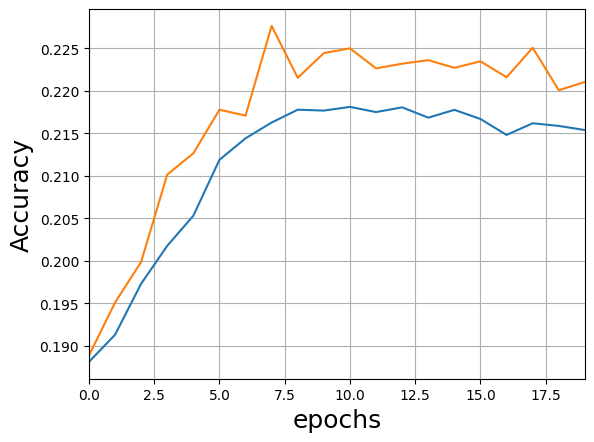

In [103]:
plt.figure()
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.xlabel('epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xlim([0,19])
plt.grid()
plt.show()

